In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install HTMLParser

  Created wheel for HTMLParser: filename=HTMLParser-0.0.2-py3-none-any.whl size=5983 sha256=883fd8ecc635ec113ecfd016d2dc767fdd295f6a519c9a465c0cae0ecf728a07
  Stored in directory: /root/.cache/pip/wheels/88/0f/43/11747d95b28379b346c15f935f4d4075e7a4ec068d3a510c79
Successfully built HTMLParser


In [5]:
import json
import pandas as pd

df = pd.read_json("/content/drive/My Drive/5001_Group/Sarcasm_Headlines_Dataset.json", lines=True)
df = df[['headline', 'is_sarcastic']]

In [6]:
print("NAN in headlines: \n", df.headline.isnull().any())
print("NAN in labels: \n", df.is_sarcastic.isnull().any())

NAN in headlines: 
 False
NAN in labels: 
 False


In [10]:
import string
import re

df['headline'] = df.headline.apply(lambda x:x.lower())
df['headline'] = df.headline.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))

df['num_of_words'] = df.headline.apply(lambda x: len(list(x.split())))
df['used_words'] = df.headline.apply(lambda x: len(set(x.split())))
df['has_digits'] = df.headline.apply(lambda x: bool(re.search(r'\d', x)))

,headline,is_sarcastic,num_of_words,used_words,has_digits
0,former versace store clerk sues over secret bl...,0,12,12,False
1,the roseanne revival catches up to our thorny ...,0,14,14,False
2,mom starting to fear son's web series closest ...,1,14,13,False
3,boehner just wants wife to listen not come up ...,1,13,13,False
4,j.k rowling wishes snape happy birthday in the...,0,11,11,False


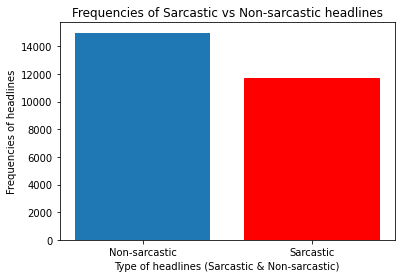

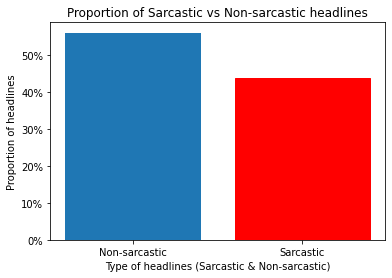

Non-sarcastic    0.56
Sarcastic        0.44
Name: used_words, dtype: float64


In [14]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

sarcastic_dat = df.groupby('is_sarcastic').count()
sarcastic_dat.index = ['Non-sarcastic','Sarcastic']
plt.xlabel('Type of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.used_words)
bar_graph[1].set_color('r')
plt.show()


plt.xlabel('Type of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Proportion of headlines')
plt.xticks(fontsize=10)
plt.title('Proportion of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.used_words / sarcastic_dat.used_words.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

print(round(sarcastic_dat.used_words / sarcastic_dat.used_words.sum(), 2))

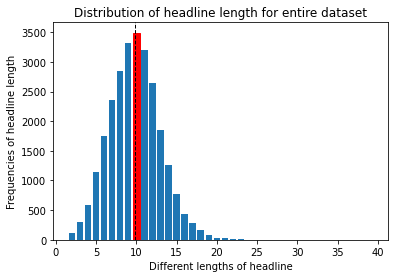

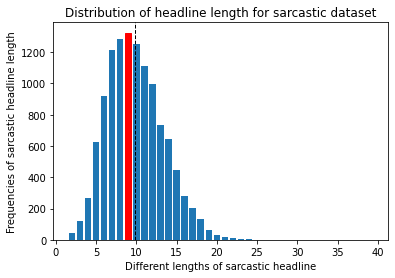

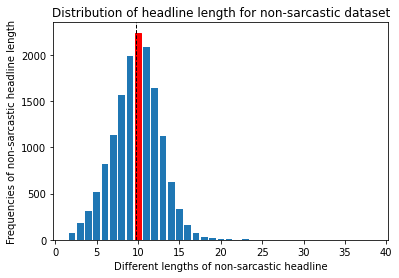

In [17]:
all_dat = df.groupby('num_of_words').count()
sarcastic_dat1 = df[df.is_sarcastic==1]
sarcastic_dat = sarcastic_dat1.groupby('num_of_words').count()
not_sarcastic_dat1 = df[df.is_sarcastic==0]
not_sarcastic_dat = not_sarcastic_dat1.groupby('num_of_words').count()

plt.xlabel('Different lengths of headline')
plt.ylabel('Frequencies of headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for entire dataset')
bar_graph = plt.bar(all_dat.index, all_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(df.num_of_words.mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

plt.xlabel('Different lengths of sarcastic headline')
plt.ylabel('Frequencies of sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for sarcastic dataset')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline)
bar_graph[7].set_color('r')
plt.axvline(sarcastic_dat1.num_of_words.mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()


plt.xlabel('Different lengths of non-sarcastic headline')
plt.ylabel('Frequencies of non-sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for non-sarcastic dataset')
bar_graph = plt.bar(not_sarcastic_dat.index, not_sarcastic_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(not_sarcastic_dat1.num_of_words.mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

In [18]:
import nltk
import spacy
from spacy.lang.en import English
import en_core_web_sm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim import corpora
import pickle

nltk.download('stopwords')
nltk.download('wordnet')

nlp = en_core_web_sm.load()
parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
  clean_tokens = []
  tokens = parser(text)
  for token in tokens:
    if token.orth_.isspace():
      continue
    elif token.like_url:
      clean_tokens.append('URL')
    elif token.orth_.startswith('@'):
      clean_tokens.append('SCREEN_NAME')
    else:
      clean_tokens.append(token.lower_)
  return clean_tokens

def get_lemma(word):
  lemma = wn.morphy(word)
  if lemma is None:
    return word
  else:
    return lemma

def prepare_text_for_lda(text):
  tokens = tokenize(text)
  tokens = [token for token in tokens if len(token) > 4]
  tokens = [token for token in tokens if token not in en_stop]
  tokens = [get_lemma(token) for token in tokens]
  return tokens

texts = []
for headline in df.headline:
  tokens = prepare_text_for_lda(headline)
  texts.append(tokens)

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
pickle.dump(corpus, open('corpus.pkl', 'wb'))  
dictionary.save('dictionary.gensim')

NUM_TOPICS = [3, 5, 10]
for i in NUM_TOPICS:
  ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=dictionary, passes=15)
  ldamodel.save('model' + str(i) + '.gensim')
  topics = ldamodel.print_topics(num_words=5)
  print(topics)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[(0, '0.013*"report" + 0.009*"people" + 0.007*"still" + 0.006*"american" + 0.005*"study"'), (1, '0.027*"trump" + 0.015*"woman" + 0.009*"donald" + 0.006*"clinton" + 0.005*"change"'), (2, '0.008*"house" + 0.008*"world" + 0.007*"white" + 0.006*"right" + 0.005*"school"')]
[(0, '0.012*"trump" + 0.009*"state" + 0.008*"school" + 0.006*"first" + 0.006*"student"'), (1, '0.007*"report" + 0.007*"study" + 0.006*"court" + 0.006*"find" + 0.006*"woman"'), (2, '0.022*"trump" + 0.011*"woman" + 0.009*"donald" + 0.009*"change" + 0.007*"really"'), (3, '0.008*"woman" + 0.007*"clinton" + 0.006*"hillary" + 0.006*"break" + 0.005*"reason"'), (4, '0.014*"house" + 0.012*"trump" + 0.012*"white" + 0.004*"hope" + 0.004*"national"')]
[(0, '0.094*"trump" + 0.028*"donald" + 0.022*"house" 

In [23]:
pip install pyLDAvis

In [24]:
import pyLDAvis.gensim_models

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))

# lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
# lda_display3 = pyLDAvis.gensim_models.prepare(lda3, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display3)

# lda5 = gensim.models.ldamodel.LdaModel.load('model5.gensim')
# lda_display5 = pyLDAvis.gensim_models.prepare(lda5, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display5)

lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_display10 = pyLDAvis.gensim_models.prepare(lda10, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display10)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

In [25]:
from numpy import mean

sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda10[corpus[headline]] # lda3/lda5/lad10
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 10 clusters:')
print('\nFor Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda10[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

For LDA model with 10 clusters:

For Sarcastic Dataset:
[(0, 0.20900562), (1, 0.01172202), (2, 0.092878394), (3, 0.01172156), (4, 0.011721161), (5, 0.011720769), (6, 0.30456132), (7, 0.19851652), (8, 0.011721645), (9, 0.136431)]

For Non-sarcastic Dataset:
[(0, 0.26404992), (1, 0.011891559), (2, 0.07538676), (3, 0.011890965), (4, 0.011890766), (5, 0.011890345), (6, 0.2410044), (7, 0.25064227), (8, 0.011891464), (9, 0.10946156)]
